In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import collections
from math import pi, cos, sin, cosh, tanh
from scipy.spatial.transform import Rotation as Rot
import cv2
import plotting
from plotting import *
import interpolation
from interpolation import *
import ficks
from ficks import *
import structure
from structure import *
import scipy.interpolate
import scipy.integrate
import scipy.stats
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, LinearRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema
from statistics import median

In [2]:
#
# DO NOT TOUCH. Define colors and states for plotting events.
#
STATES = ['fix', 'sac', 'smp', 'vor', 'blink', 'fix_blink', 'noise', 'other', 'loss']
COLORS = {'fix':'red', 'sac':'lime', 'smp':'purple', 'vor':'brown', 'blink':'dodgerblue', 'fix_blink':'darkorchid', 'noise':'turquoise', 'other':'grey', 'loss':'gold'}
BORDERS = {'fix':'magenta', 'sac':'green', 'smp':'blue', 'vor':'tan', 'blink':'royalblue', 'fix_blink':'darkviolet', 'noise':'lightseagreen', 'other':'black', 'loss':'yellow'}
BINS = 50

## Set desired parameters

## Define functions

### probability functions

In [3]:
def gaussian(x, mu, std):
    return (1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/std)**2)

### functions used for Carpenter's theorem

In [4]:
def carpenter(a):
    """
    A function that takes in amplitude ($\degree$) and returns duration (sec).
    """
    return (21 + 2.2*a)/1000

# Step 0: Collect and pre-process the data

In [5]:
#
# Select which dataset to use
#
sample_rates = {'varjo':200, 'PI':66}
in_path = '/data/Isabella/thesis_spring2022/event_detect_in/'

DEVICE = 'varjo'
subID = 'P2' #'P4_right_cereal' good one to use, despite Nystagmus. 'P13_right_cereal' crashes - high Nystagmus.
eye = 'right'
task = 'cereal'
SAMPLE_RATE = sample_rates[DEVICE]
MIN_FIX_DUR = 0.1 #np.ceil(100 - 4*1/SAMPLE_RATE*1000)/1000
max_sac_dur = 0.6 #given that max span of human vision is 180deg horizontal & 200deg vertical & max vel is 1000deg/s

ID = f'{DEVICE}_{task}_{eye}_{subID}.csv'
df = pd.read_csv(in_path+ID)

In [6]:
MIN_FIX_DUR

0.1

In [7]:
print(f'Percent of Nans: x-deg {np.round(len(df[np.isnan(df.x_deg)])/len(df.x_deg),4)*100}%, y-deg {np.round(len(df[np.isnan(df.y_deg)])/len(df.y_deg),4)*100}%')

Percent of Nans: x-deg 1.32%, y-deg 1.32%


In [8]:
df.head()

,Unnamed: 0,time,x_deg,y_deg,iss,issy
0,0,0.997333,-11.793022,1.341139,6.693539,6.693539
1,1,1.002335,-11.825344,1.169388,34.939889,34.939889
2,2,1.007337,-11.858738,1.106688,14.201777,14.201777
3,3,1.012339,-11.699225,1.247880,42.586364,42.586364
4,4,1.017341,-11.896689,1.255224,39.501771,39.501771


## Visualize the features

<IPython.core.display.Javascript object>


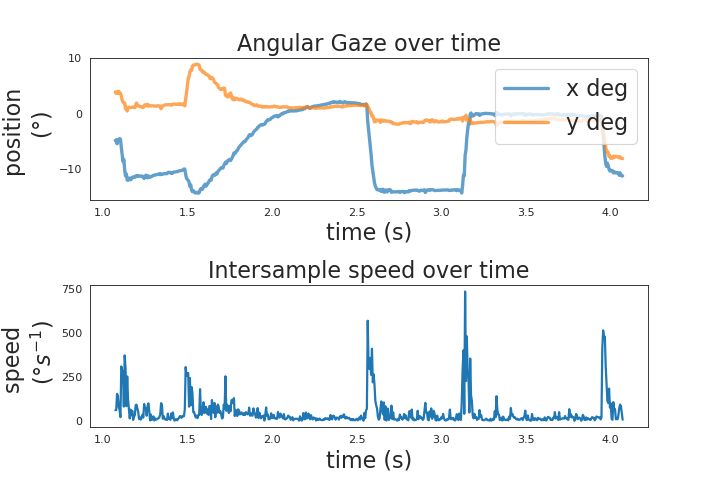

In [9]:
# get dataframe for chosen participant
df['event'] = 'other'

# visual check of normalized gaze features
START, END = 200, 800 # set where you want subsample of graph to be (used in visuals)

plt.figure(figsize=(9,6)) # Set the plot size

# Plot position (angles)
plt.subplot(2,1,1)
plt.plot((df.time-df.time[0])[START:END], df.x_deg[START:END], alpha = 0.7, linewidth=3, label = 'x deg')
plt.plot((df.time-df.time[0])[START:END], df.y_deg[START:END], alpha = 0.7, linewidth=3, label = 'y deg')
plt.ylabel('position \n ($\degree$)', fontsize=20)
plt.xlabel('time (s)', fontsize = 20)
plt.legend(loc='upper right',fontsize=20)
plt.title('Angular Gaze over time', fontsize=20)

# Plot speed
plt.subplot(2,1,2)
plt.plot((df.time-df.time[0])[START:END], df.iss[START:END], linewidth = 2, label='intersample speed')
plt.ylabel('speed \n ($\degree s^{-1}$)', fontsize=20)
plt.xlabel('time (s)', fontsize=20)
plt.title('Intersample speed over time', fontsize = 20)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.subplots_adjust(hspace=0.6)

plt.show()

<IPython.core.display.Javascript object>


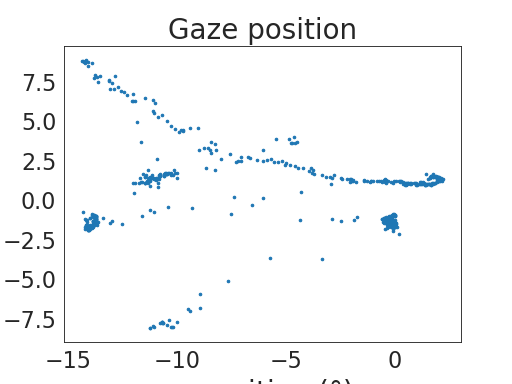

In [10]:
#%matplotlib inline
plt.figure()
plt.scatter(df.x_deg[START:END], df.y_deg[START:END], s=5)
plt.ylabel('y-position ($\degree$)', fontsize=25)
plt.xlabel('x-position ($\degree$)', fontsize=25)
plt.title('Gaze position', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


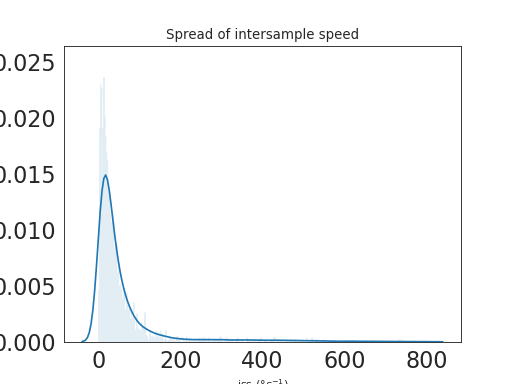

In [11]:
plt.figure()
sns.distplot(df[~np.isnan(df.iss)].iss, len(df)//10)
plt.title("Spread of intersample speed")
plt.ylabel("Count")
plt.xlabel("iss ($\degree s^{-1}$)")
plt.show()

In [12]:
df.head()

,Unnamed: 0,time,x_deg,y_deg,iss,issy,event
0,0,0.997333,-11.793022,1.341139,6.693539,6.693539,other
1,1,1.002335,-11.825344,1.169388,34.939889,34.939889,other
2,2,1.007337,-11.858738,1.106688,14.201777,14.201777,other
3,3,1.012339,-11.699225,1.247880,42.586364,42.586364,other
4,4,1.017341,-11.896689,1.255224,39.501771,39.501771,other


In [13]:
len(df)

22665

# Classify events

## Steps to event detection:

### Step 0: Pre-process
- 0.1 Calculate intersample velocity v.
- 0.2 Remove noise by replacing x,y,v with NAN where v > 1000 and v<=0.
- 0.3 Label loss where there is a difference in time greater than 400 ms between samples.
- 0.4 Up-sample angular positional features x, y where there are gaps in data above 3xSAMPLE_RATE but less than 400 ms using cubic intervariate spline method.
- 0.5 Interpolate the upsampled angular positional features (Dx, Dy) and find their derivatives.

### Step 1: Low- vs High-speed events
- Calculate feature Dn = sqrt(diff(dDx/dt)+diff(dDy/dt))
- Run EM-GMM to calculate priors and likelihoods for low- and high-speed.
- Calculate probabilities for low- and high-speed sample-by-sample.
- Label samples where p(L) >= p(H) as low-speed, otherwise high-speed. 
- Create events_df from labelled events.

### Step 2: Within movement classify saccades and blinks
- Calculate feature Dv = abs(max-min) from diff(dDy/dt) (vertical interpolated velocity) for all non-loss events.
- Run EM-GMM on distribution of Dv in high-speed events to calculate priors and likelihoods for sac or blink.
- Calculate joint probabilities for sac and blink event-by-event, conditional on the probability of the event being a high-speed event.

### Step 3: Within fixations distinguish between fixations and smooth pursuits
(which could also be VOR since we don't account for head rotation)
- Calculate amplitude feature as Da = sqrt((Dx_t-Dx_0)^2+(Dy_t-Dy_0)^2) for all non-loss events (unless fixation, then Da = std(x)+std(y).
- Run EM-GMM on distribution of Da in low-speed events to calculate priors and likelihoods for fix or smp.
- Calculate probabilities for fix or smp event-by-event, conditional on the probability of the event being a low-speed event.

### Step 4: Classify events
- For each event in events_df, classify the event as that which has the highest probability

## Step 0: Pre-process

In [14]:
df_0 = df.copy()

In [15]:
df = df_0.copy()

<IPython.core.display.Javascript object>


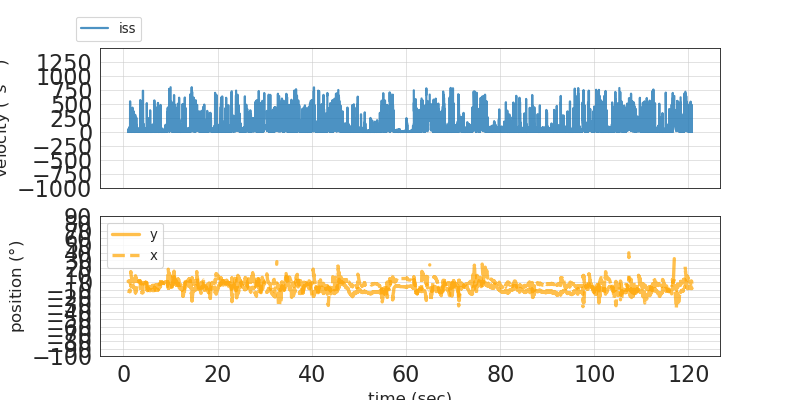

In [16]:
makePlot2(df, show_events=[], show_events_bool=False)

In [17]:
np.sqrt((-16+17)**2+(4.6-6.5)**2)/(.84587-.84086)

428.56108889389355

In [128]:
# from math import dist
# iss, isv, issy = [np.NAN], [np.NAN], [np.NAN]
# time, x_deg, y_deg = df.time, df.x_deg, df.y_deg
# for i in range(1, len(time)):
#     if np.isnan(x_deg[i-1]) or np.isnan(x_deg[i]) or np.isnan(y_deg[i-1]) or np.isnan(y_deg[i]):
#         iss.append(np.NAN)
#         isv.append(np.NAN)
#         issy.append(np.NAN)
#     else:
#         ds = np.sqrt((x_deg[i]-x_deg[i-1])**2+(y_deg[i]-y_deg[i-1])**2)
#         #dv = (x_deg[i]-x_deg[i-1])+(y_deg[i]-y_deg[i-1])
#         dv = dist((x_deg[i-1],y_deg[i-1]),(x_deg[i],y_deg[i]))
#         s = ds/(time[i]-time[i-1])
#         v = dv/(time[i]-time[i-1])
#         iss.append(s)
#         isv.append(v)

#         vy = (y_deg[i]-y_deg[i-1])/(time[i]-time[i-1])
#         issy.append(vy)

In [129]:
# from scipy.stats import pearsonr
# isv = [v for v in isv if ~np.isnan(v)]
# iss = [s for s in iss if ~np.isnan(s)]
# r, p = pearsonr(iss,isv)
# print(f'r {r}, p {p}, r^2 {r**2}')

In [130]:
# Detect loss and replace with NANs
max_interp_dur = 0.4 # seconds
to_drop = []
for idx, row in df[1:].copy().iterrows():
    if idx in to_drop:
        continue
    i = idx+1
    prev_row = df.loc[idx-1]
    dt = row.time - prev_row.time
    if dt > max_interp_dur: #.01 for varjo (200Hz)
        df.loc[idx-1:i, 'event'] = 'loss'
        df.loc[idx-1:i, 'x_deg':'issy'] = np.NAN
#         # combine consecutive gaps
#         while i < len(df)-1 and df.loc[i,'time']-df.loc[i-1, 'time'] > 1/SAMPLE_RATE:
#             i += 1
#         dt = df.loc[i-1,'time'] - prev_row.time
#         # mark event as loss if the gap is more than max_interp_dur long
#         if dt > max_interp_dur:
#             df.loc[idx-1:i, 'event'] = 'loss'
#         # otherwise, upsample the missing data and fill it in with interpolated data only around that time
#         else:
#             # df.loc[idx-1:i, 'event'] = 'loss'
#             trange = np.linspace(prev_row.time, df.loc[i-1,'time'], num=int(dt*SAMPLE_RATE))
#             for t in trange:
#                 df = df.append({'time':t, 'x_deg':interp_x(t), 'y_deg':interp_y(t), 'event':'other'}, ignore_index=True)
#             to_drop.extend(list(range(idx-1, i)))

# df = df.drop(df.index[to_drop])
# df = df.sort_values(by='time', ascending=True, ignore_index=True)
# df = df.reset_index()
df['x_deg'] = df['x_deg'].astype(np.float)
df['y_deg'] = df['y_deg'].astype(np.float)

In [131]:
len(df[df.event=='loss'])

0

In [132]:
len(df)

31124

In [133]:
# # Interpolate over the upsampled x and y that now have gaps filled in. (cubic interpolation)
# interp_x = interpolate(df, SAMPLE_RATE, feat='x_deg')
# interp_y = interpolate(df, SAMPLE_RATE, feat='y_deg')

# interp_dx = interp_x.derivative()
# interp_dy = interp_y.derivative()

In [134]:
# Calculate interpolated velocity
interp_v = interpolate(df, SAMPLE_RATE, feat='iss')
df['Dn'] = interp_v(df.time)

<IPython.core.display.Javascript object>


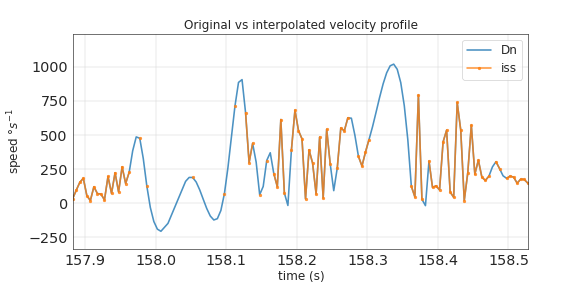

In [137]:
# Show difference in features between interpolated intersample speed (Dn) and iss before interpolation.
# Note that Dn could be greater than 1000 deg/s, but we leave it because it could show blinks.
plt.figure(figsize=(9,4))
plt.plot(df.time,df.Dn,alpha=0.8,linewidth=2,label='Dn')
plt.plot(df.time,df.iss,'.-',alpha=0.8,linewidth=2,label='iss')
plt.title('Original vs interpolated velocity profile', fontsize=15)
plt.ylabel(r'speed $\degree s^{-1}$', fontsize=15)
plt.xlabel('time (s)', fontsize=15)
plt.legend(fontsize=15)
plt.yticks([i for i in range(-2000, 2000, 250)])
plt.grid(linewidth=0.5)
plt.show()

<IPython.core.display.Javascript object>


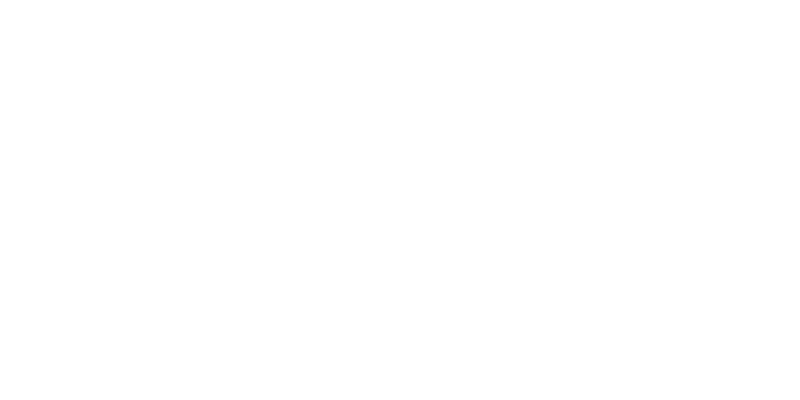

In [26]:
show_events=['other','loss']
makePlot2(df, show_events, show_events_bool=True)

## Step 1. High vs low speed events

In [27]:
# make checkpoint
check1_df = df.copy()

In [28]:
df = check1_df

In [29]:
# set features
Dn = 'Dn' # interpolated iss (quadratic)

# estimate model parameters with the EM algorithm
Dn_mixture = GaussianMixture(n_components=2).fit(df.loc[df.event!='loss', Dn].to_numpy().reshape(-1,1))
Dn_means_hat = Dn_mixture.means_.flatten()
Dn_weights_hat = Dn_mixture.weights_.flatten()
Dn_sds_hat = np.sqrt(Dn_mixture.covariances_).flatten()

print(f'mixture converged? {Dn_mixture.converged_}')
print(f'means: {Dn_means_hat}')
print(f'weights: {Dn_weights_hat}')
print(f'standard deviations: {Dn_sds_hat}')

# fix should have smaller mean than non-fix
fixi = np.argmin(Dn_means_hat)
nfixi = np.argmax(Dn_means_hat)
Dn_mu1, Dn_sd1 = Dn_means_hat[fixi], Dn_sds_hat[fixi]
Dn_mu2, Dn_sd2 = Dn_means_hat[nfixi], Dn_sds_hat[nfixi]

prior_fix = Dn_weights_hat[fixi]
prior_nonfix = Dn_weights_hat[nfixi]

mixture converged? True
means: [ 41.86369763 259.34596667]
weights: [0.65945527 0.34054473]
standard deviations: [ 31.45966991 278.13447695]


In [30]:
# sklearn's gaussian mixture model uses EM algorithm to estimate model parameters
df['P_fix'] = 0.0
df['P_nonfix'] = 0.0
df['L_fix'] = 0.0
df['L_nonfix'] = 0.0
for idx, row in df.iterrows():
    if row[Dn] < Dn_mu1:
        L_fix = norm.pdf(Dn_mu1, Dn_mu1, Dn_sd1)
    else:
        L_fix = norm.pdf(row[Dn], Dn_mu1, Dn_sd1)
    if row[Dn] > Dn_mu2:
        L_nonfix = norm.pdf(Dn_mu2, Dn_mu2, Dn_sd2)
    else:
        L_nonfix = norm.pdf(row[Dn], Dn_mu2, Dn_sd2)
    df.loc[idx, 'L_fix'] = L_fix
    df.loc[idx, 'L_nonfix'] = L_nonfix
    df.loc[idx, 'P_fix'] = (L_fix*prior_fix)/(L_fix*prior_fix + L_nonfix*prior_nonfix)
    df.loc[idx, 'P_nonfix'] = (L_nonfix*prior_nonfix)/(L_fix*prior_fix + L_nonfix*prior_nonfix)

In [31]:
# Classify fixations as those with probability greater than or equal to 50%.
df['event'] = np.where(df.event!='loss', np.where(df.P_fix>=0.5, 'fix', df.event), df.event)

# Make events_df (need to iterate twice)
# Ignore fixation events where the duration is less than the minimum duration of a fixation.
events_df = make_events_df(df, interp_v, SAMPLE_RATE, MIN_FIX_DUR)
# running it again means that consecutive events are merged into one
df = map_to_stream(events_df, df)
events_df = make_events_df(df, interp_v, SAMPLE_RATE, MIN_FIX_DUR)
#events_df = adjust_amp_dur(events_df, df, interp_v, first_run=True)

print(sum(np.where(df.P_fix>= df.P_nonfix,1,0))/len(df), sum(np.where(df.P_fix>=0.5,1,0))/len(df))

0.6990104099730112 0.6990104099730112


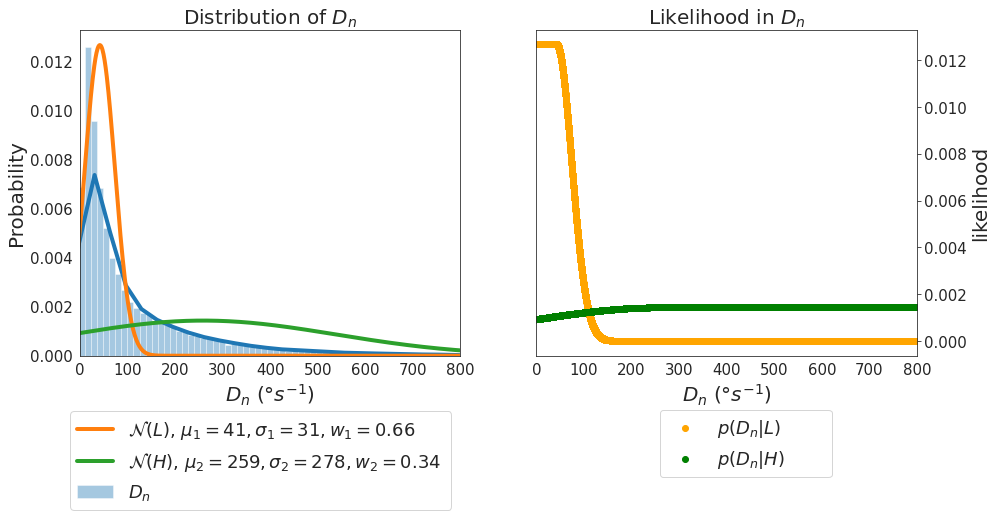

In [32]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(15,6))

x_min = min(df.loc[df[Dn]<df[Dn].quantile(.95),Dn])
x_max = max(df.loc[df[Dn]<df[Dn].quantile(.95),Dn])

sns.distplot(df[Dn], bins = 500, kde_kws=dict(linewidth=4), label = '$D_n$', ax=ax[0])
x_axis = np.linspace(Dn_mu1-3*Dn_sd1, Dn_mu2+3*Dn_sd2, 1000)
ax[0].plot(x_axis, norm.pdf(x_axis, Dn_mu1, Dn_sd1), linewidth=4, label = r'$\mathcal{N}(L)$,'+f' $\mu_1={int(Dn_mu1)}, \sigma_1={int(Dn_sd1)}, w_1={np.round(prior_fix,2)}$')
ax[0].plot(x_axis, norm.pdf(x_axis, Dn_mu2, Dn_sd2), linewidth=4, label = r'$\mathcal{N}(H)$,'+f' $\mu_2={int(Dn_mu2)}, \sigma_2={int(Dn_sd2)}, w_2={np.round(prior_nonfix,2)}$')
ax[0].legend(bbox_to_anchor=(-0.05,-0.5,1.05,0), loc='lower center', mode='expand',fontsize=18)
ax[0].set_title('Distribution of $D_n$',fontsize=20)
ax[0].set_xlabel('$D_n$ ($\degree s^{-1}$)',fontsize=20)
ax[0].set_ylabel('Probability',fontsize=20)
ax[0].set_xlim(0,800)

ax[1].scatter(df[Dn], df.L_fix, color='orange', label='$p(D_n|L)$')
ax[1].scatter(df[Dn], df.L_nonfix, color='green', label='$p(D_n|H)$')
ax[1].legend(bbox_to_anchor=(0.3,-0.4,.5,0), loc='lower center', mode='expand',fontsize=18)
ax[1].set_xlabel('$D_n$ ($\degree s^{-1}$)',fontsize=20)
ax[1].set_ylabel('likelihood',fontsize=20)
ax[1].set_title('Likelihood in $D_n$',fontsize=20)
ax[1].set_xlim(0,800)
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [33]:
%matplotlib notebook

<IPython.core.display.Javascript object>


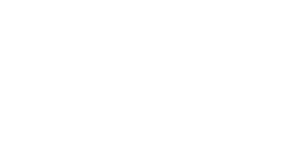

In [34]:
show_events_bool=True
show_events=['fix','other','noise']
makePlot2(df, show_events, show_events_bool=True)

## Step 2. Saccade vs Blink in high-speed events

In [35]:
# make checkpoint
check2_events_df = events_df.copy()
check2_df = df.copy()

In [36]:
events_df = check2_events_df.copy()
df = check2_df.copy()

In [37]:
# set Dv feature
Dv = 'calculus_error'

# estimate model parameters with the EM algorithm for non-fix events
Dv_mixture = GaussianMixture(n_components=2).fit(events_df.loc[events_df.event=='other', Dv].to_numpy().reshape(-1,1))
Dv_means_hat = Dv_mixture.means_.flatten()
Dv_weights_hat = Dv_mixture.weights_.flatten()
Dv_sds_hat = np.sqrt(Dv_mixture.covariances_).flatten()

print(f'mixture converged? {Dv_mixture.converged_}')
print(f'means: {Dv_means_hat}')
print(f'weights: {Dv_weights_hat}')
print(f'standard deviations: {Dv_sds_hat}')

# sac should have smaller mean than blink
saci = np.argmin(Dv_means_hat)
blinki = np.argmax(Dv_means_hat)
Dv_mu1, Dv_sd1 = Dv_means_hat[saci], Dv_sds_hat[saci]
Dv_mu2, Dv_sd2 = Dv_means_hat[blinki], Dv_sds_hat[blinki]

prior_sac = Dv_weights_hat[saci]
prior_blink = Dv_weights_hat[blinki]

mixture converged? True
means: [0.27850871 0.77876794]
weights: [0.34355572 0.65644428]
standard deviations: [0.17199672 0.1613035 ]


In [38]:
# sklearn's gaussian mixture model uses EM algorithm to estimate model parameters
events_df['P_sac'] = 0.0
events_df['P_blink'] = 0.0
events_df['L_sac'] = 0.0
events_df['L_blink'] = 0.0
for idx, row in events_df.loc[events_df.event!='noise'].iterrows():
    if row[Dv] <= Dv_mu1:
        L_sac = norm.pdf(Dv_mu1, Dv_mu1, Dv_sd1)
    else:
        L_sac = norm.pdf(row[Dv], Dv_mu1, Dv_sd1)
    if row[Dv] > Dv_mu2:
        L_blink = norm.pdf(Dv_mu2, Dv_mu2, Dv_sd2)
    else:
        L_blink = norm.pdf(row[Dv], Dv_mu2, Dv_sd2)
    events_df.loc[idx, 'L_sac'] = L_sac
    events_df.loc[idx, 'L_blink'] = L_blink
    events_df.loc[idx, 'P_sac'] = ((L_sac*prior_sac)/(L_sac*prior_sac + L_blink*prior_blink))*row.P_nonfix
    events_df.loc[idx, 'P_blink'] = ((L_blink*prior_blink)/(L_sac*prior_sac + L_blink*prior_blink))*row.P_nonfix

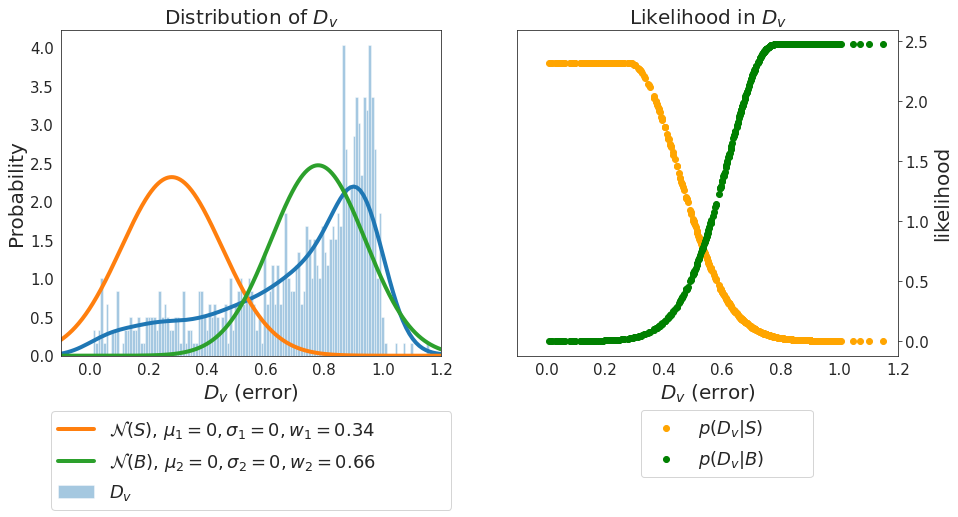

In [39]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(15,6))

x_min = min(events_df.loc[(events_df.event!='noise')&(events_df[Dv]<events_df[Dv].quantile(.98)), Dv])
x_max = max(events_df.loc[(events_df.event!='noise')&(events_df[Dv]<events_df[Dv].quantile(.98)), Dv])

sns.distplot(events_df.loc[events_df.event!='noise', Dv], bins = 200, kde_kws=dict(linewidth=4), label = '$D_v$', ax=ax[0])
x_axis = np.linspace(Dv_mu1-3*Dv_sd1, Dv_mu2+3*Dv_sd2, 1000)
ax[0].plot(x_axis, norm.pdf(x_axis, Dv_mu1, Dv_sd1), linewidth=4, label = r'$\mathcal{N}(S)$,'+f' $\mu_1={int(Dv_mu1)}, \sigma_1={int(Dv_sd1)}, w_1={np.round(prior_sac,2)}$')
ax[0].plot(x_axis, norm.pdf(x_axis, Dv_mu2, Dv_sd2), linewidth=4, label = r'$\mathcal{N}(B)$,'+f' $\mu_2={int(Dv_mu2)}, \sigma_2={int(Dv_sd2)}, w_2={np.round(prior_blink,2)}$')
ax[0].legend(bbox_to_anchor=(-.05,-0.5,1.1,0), loc='lower center', mode='expand',fontsize=18)
ax[0].set_title('Distribution of $D_v$',fontsize=20)
ax[0].set_xlabel('$D_v$ (error)',fontsize=20)
ax[0].set_ylabel('Probability',fontsize=20)
ax[0].set_xlim(-0.1,1.2)

ax[1].scatter(events_df.loc[events_df.event!='noise', Dv], events_df.loc[events_df.event!='noise', 'L_sac'], color='orange', label='$p(D_v|S)$')
ax[1].scatter(events_df.loc[events_df.event!='noise', Dv], events_df.loc[events_df.event!='noise', 'L_blink'], color='green', label='$p(D_v|B)$')
ax[1].legend(bbox_to_anchor=(0.3,-0.4,.5,0), loc='lower center', mode='expand',fontsize=18)
ax[1].set_xlabel('$D_v$ (error)',fontsize=20)
ax[1].set_ylabel('likelihood',fontsize=20)
ax[1].set_title('Likelihood in $D_v$',fontsize=20)
ax[1].set_xlim(-0.1,1.2)
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [40]:
%matplotlib notebook

## Step 3. Detect smp (or VOR) in low-speed events

In [41]:
# make checkpoint
check3_events_df = events_df.copy()
check3_df = df.copy()

In [42]:
events_df = check3_events_df.copy()
df = check3_df.copy()

In [43]:
# set Da feature
Da = 'dispersion'

# estimate model parameters with the EM algorithm
Da_mixture = GaussianMixture(n_components=2).fit(events_df.loc[events_df.event=='fix', Da].to_numpy().reshape(-1,1))
Da_means_hat = Da_mixture.means_.flatten()
Da_weights_hat = Da_mixture.weights_.flatten()
Da_sds_hat = np.sqrt(Da_mixture.covariances_).flatten()

print(f'mixture converged? {Da_mixture.converged_}')
print(f'means: {Da_means_hat}')
print(f'weights: {Da_weights_hat}')
print(f'standard deviations: {Da_sds_hat}')

# fix should have smaller mean than smp/vor
fixi = np.argmin(Da_means_hat)
smpi = np.argmax(Da_means_hat)
Da_mu1, Da_sd1 = Da_means_hat[fixi], Da_sds_hat[fixi]
Da_mu2, Da_sd2 = Da_means_hat[smpi], Da_sds_hat[smpi]

prior_ff = Da_weights_hat[fixi]
prior_smp = Da_weights_hat[smpi]

mixture converged? True
means: [0.99953425 2.5739799 ]
weights: [0.81036226 0.18963774]
standard deviations: [0.30936906 1.32464287]


In [44]:
# sklearn's gaussian mixture model uses EM algorithm to estimate model parameters
events_df['P_ff'] = 0.0
events_df['P_smp'] = 0.0
events_df['L_ff'] = 0.0
events_df['L_smp'] = 0.0
for idx, row in events_df.iterrows():
    if row[Da] <= Da_mu1:
        L_ff = norm.pdf(Da_mu1, Da_mu1, Da_sd1)
    else:
        L_ff = norm.pdf(row[Da], Da_mu1, Da_sd1)
    if row[Da] > Da_mu2:
        L_smp = norm.pdf(Da_mu2, Da_mu2, Da_sd2)
    else:
        L_smp = norm.pdf(row[Da], Da_mu2, Da_sd2)
    events_df.loc[idx, 'L_ff'] = L_ff
    events_df.loc[idx, 'L_smp'] = L_smp
    events_df.loc[idx, 'P_ff'] = (L_ff*prior_ff)/(L_ff*prior_ff + L_smp*prior_smp)*row.P_fix
    events_df.loc[idx, 'P_smp'] = (L_smp*prior_smp)/(L_ff*prior_ff + L_smp*prior_smp)*row.P_fix

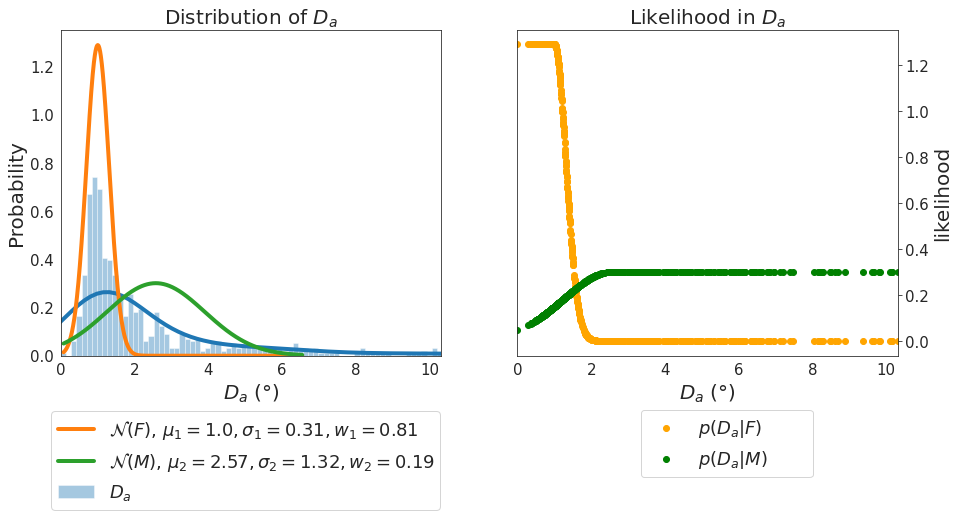

In [45]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(15,6))

x_min = min(events_df.loc[events_df[Da]<events_df[Da].quantile(.95), Da])
x_max = max(events_df.loc[events_df[Da]<events_df[Da].quantile(.95), Da])

sns.distplot(events_df[Da], bins = 200, kde_kws=dict(linewidth=4), label = '$D_a$', ax=ax[0])
x_axis = np.linspace(Da_mu1-3*Da_sd1, Da_mu2+3*Da_sd2, 1000)
ax[0].plot(x_axis, norm.pdf(x_axis, Da_mu1, Da_sd1), linewidth=4, label = r'$\mathcal{N}(F)$,'+f' $\mu_1={np.round(Da_mu1,2)}, \sigma_1={np.round(Da_sd1,2)}, w_1={np.round(prior_ff,2)}$')
ax[0].plot(x_axis, norm.pdf(x_axis, Da_mu2, Da_sd2), linewidth=4, label = r'$\mathcal{N}(M)$,'+f' $\mu_2={np.round(Da_mu2,2)}, \sigma_2={np.round(Da_sd2,2)}, w_2={np.round(prior_smp,2)}$')
ax[0].legend(bbox_to_anchor=(-.05,-0.5,1.07,0), loc='lower center', mode='expand',fontsize=18)
ax[0].set_title('Distribution of $D_a$',fontsize=20)
ax[0].set_xlabel('$D_a$ ($\degree$)',fontsize=20)
ax[0].set_ylabel('Probability',fontsize=20)
ax[0].set_xlim(x_min,x_max)

ax[1].scatter(events_df[Da], events_df.L_ff, color='orange', label='$p(D_a|F)$')
ax[1].scatter(events_df[Da], events_df.L_smp, color='green', label='$p(D_a|M)$')
ax[1].legend(bbox_to_anchor=(0.3,-0.4,.5,0), loc='lower center', mode='expand',fontsize=18)
ax[1].set_xlabel('$D_a$ ($\degree$)',fontsize=20)
ax[1].set_ylabel('likelihood',fontsize=20)
ax[1].set_title('Likelihood in $D_a$',fontsize=20)
ax[1].set_xlim(x_min,x_max)
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [46]:
%matplotlib notebook

## Classify events

In [47]:
# Classify events as that with the largest probability
s = ['fix', 'smp', 'sac', 'blink']
for idx, row in events_df[(events_df.event!='loss')&(events_df.event!='noise')&(events_df.event!='blink')].iterrows():
    i = np.argmax([row.P_ff, row.P_smp, row.P_sac, row.P_blink])
    events_df.loc[idx, 'event'] = s[i]

df = map_to_stream(events_df, df)


In [48]:
#
# Step 4.1: Adjustments
#
# Merge events broken up by noise with recalculated features and drop the noise
to_drop = []
for idx, row in events_df.copy().iterrows():
    if idx == 0 or idx == len(events_df)-1:
        continue

    prev_row = events_df.loc[idx-1]
    next_row = events_df.loc[idx+1]

    # if noise occurs between the same event
    if row.event == 'noise' and prev_row.event == next_row.event:

        events_df = merge_events(df, events_df, idx-1, idx+1, prev_row.event, interp_v, SAMPLE_RATE)
        to_drop.extend([idx,idx+1])

# drop events that are now merged
events_df = events_df.drop(to_drop)
events_df.reset_index(inplace=True)
del events_df['index']

# map the updated events_df to df
df = map_to_stream(events_df, df)

# adjust amplitude and related features for non-fixations between two fixations
events_df = adjust_amp_dur(events_df, df, interp_v)


# ADJUSTMENTS
# relabel smp as sac if carpenter error is less than threshold
avg_sac_carp_error_plus_two_std = events_df[events_df.event=='sac'].carpenter_error.mean()+2*events_df[events_df.event=='sac'].carpenter_error.std()
events_df.loc[(events_df.event=='smp')&(events_df.carpenter_error<=avg_sac_carp_error_plus_two_std), 'event'] = 'sac'

# remove saccades and smooth pursuits with amplitude below 1.5
events_df = events_df.drop(events_df.loc[(events_df.amplitude<1.5)&(events_df.event=='sac')].index)
events_df.reset_index(inplace=True)
del events_df['index']
events_df = events_df.drop(events_df.loc[(events_df.amplitude<1.5)&(events_df.event=='smp')].index)
events_df.reset_index(inplace=True)
del events_df['index']

In [49]:
df_ = df.copy()
events_df_ = events_df.copy()

In [50]:
df = df_.copy()
events_df = events_df_.copy()

In [51]:
%matplotlib notebook

<IPython.core.display.Javascript object>


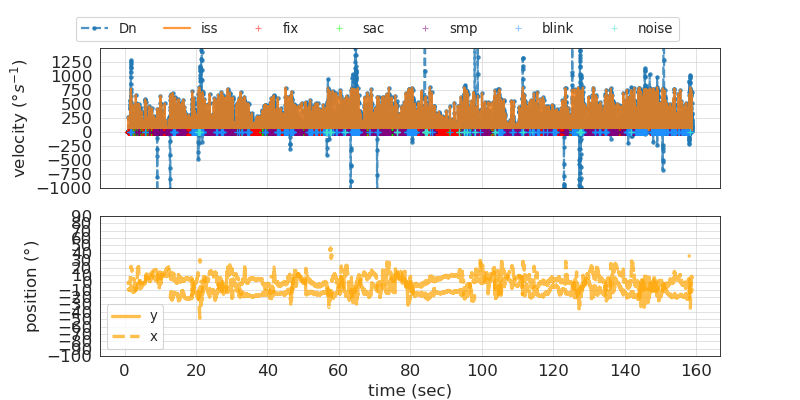

In [52]:
show_events_bool=True
show_events=['fix','sac','smp','blink','noise']
makePlot2(df, show_events, show_events_bool=True)

In [53]:
sum(events_df.loc[2,['P_ff','P_sac','P_smp','P_blink']])

0.9999999999999999

## Physiological adjustments

In [54]:
# relabel smp as sac if carpenter error is less than threshold
avg_sac_carp_error_plus_two_std = events_df[events_df.event=='sac'].carpenter_error.mean()+2*events_df[events_df.event=='sac'].carpenter_error.std()
events_df.loc[(events_df.event=='smp')&(events_df.carpenter_error<=avg_sac_carp_error_plus_two_std), 'event'] = 'sac'


# remove saccades and smooth pursuits with amplitude below 1.5
events_df = events_df.drop(events_df.loc[(events_df.amplitude<1.5)&(events_df.event=='sac')].index)
events_df.reset_index(inplace=True)
del events_df['index']
events_df = events_df.drop(events_df.loc[(events_df.amplitude<1.5)&(events_df.event=='smp')].index)
events_df.reset_index(inplace=True)
del events_df['index']


# mark events with calculus error above 1.5 (from paper) as noise (non-movements)
events_df.loc[events_df.calculus_error>1.5, 'event'] = 'noise'


## Merge around blinks and noise

In [55]:
test_df = df.copy()
test_events_df = events_df.copy()

In [56]:
#
# Algo 5.1: Merge around blinks
#
test_df = df.copy()
test_events_df = events_df.copy()

# Calculate statistical thresholds based on the data:
# use two std for amplitude bc system noise in spatial data
# use one std for carpenter bc error calculation
avg_fix_amp_plus_two_std = test_events_df[test_events_df.event=='fix'].amplitude.mean()+2*test_events_df[test_events_df.event=='fix'].amplitude.std()
avg_sac_carp_error_plus_two_std = test_events_df[test_events_df.event=='sac'].carpenter_error.mean()+2*test_events_df[test_events_df.event=='sac'].carpenter_error.std()
avg_sac_calc_error_plus_two_std = test_events_df[test_events_df.event=='sac'].calculus_error.mean()+test_events_df[test_events_df.event=='sac'].calculus_error.std()

to_drop = []
for idx, row in test_events_df.copy().iterrows():
    if idx == 0 or idx == len(test_events_df)-1:
        continue

    prev_row = test_events_df.loc[idx-1]
    next_row = test_events_df.loc[idx+1]

    # if a blink or noise occurs between the same event
    if row.event == 'blink' and prev_row.event == next_row.event:

        # if the neighboring events are fixations whose centers vary less than a threshold,
        #  then merge the two neighboring events
        if prev_row.event == 'fix' and np.sqrt((next_row.center_x-prev_row.center_x)**2+(next_row.center_y-prev_row.center_y)**2) <= avg_fix_amp_plus_two_std:
            test_events_df = merge_events(test_df, test_events_df,idx-1,idx+1,'fix',interp_v, SAMPLE_RATE,blink=True)
            to_drop.extend([idx,idx+1])
            # Flag in df where the blink used to be
            test_df.loc[row.start_i:row.end_i, 'has_blink'] = True
        else:   
            amplitude = np.sqrt((next_row.x0-prev_row.xn)**2+(next_row.y0-prev_row.yn)**2)
            duration = next_row.start_s-prev_row.end_s
            carpenter_error = np.abs(duration*1000 - (21 + 2.2 * amplitude))/(21 + 2.2 * amplitude)
            # if the blink follows saccadic behavior according to carpenter, 
            # then it's likely a saccade with blink
            if carpenter_error <= avg_sac_carp_error_plus_two_std:
                # if the neighboring events are also saccades, then merge into one saccade
                if prev_row.event == 'sac':
                    test_events_df = merge_events(test_df, test_events_df,idx-1,idx+1, 'sac', interp_v, SAMPLE_RATE,blink=True)
                    to_drop.extend([idx,idx+1])
                # otherwise reclassify the blink as a saccade
                else:
                    test_df.loc[row.start_i:row.end_i, 'event'] = 'sac'
                    test_events_df.loc[idx, 'event'] = 'sac'
                    test_events_df.loc[idx, 'has_blink'] = True
                    # Flag in df where the blink used to be
                    test_df.loc[row.start_i:row.end_i, 'has_blink'] = True
            # otherwise merge the neigboring events, ignoring the blink
            else:
                event = prev_row.event
                test_events_df = merge_events(test_df, test_events_df,idx-1,idx+1,event,interp_v, SAMPLE_RATE,blink=True)
                to_drop.extend([idx,idx+1])
                # Flag in df where the blink used to be
                test_df.loc[row.start_i:row.end_i, 'has_blink'] = True

    # Otherwise, if a blink breaks up separate events (neither of which is loss)
    elif row.event == 'blink' and prev_row.event!='loss' and next_row.event!='loss':
        amplitude = np.sqrt((next_row.x0-prev_row.xn)**2+(next_row.y0-prev_row.yn)**2)
        duration = next_row.start_s-prev_row.end_s
        carpenter_error = np.abs(duration*1000 - (21 + 2.2 * amplitude))/(21 + 2.2 * amplitude)
        # if the blink follows saccadic behavior according to carpenter, 
        # then it's likely a saccade with blink
        if carpenter_error <= avg_sac_carp_error_plus_two_std:
            test_df.loc[row.start_i:row.end_i, 'event'] = 'sac'
            test_events_df.loc[idx, 'event'] = 'sac'
            test_df.loc[row.start_i:row.end_i, 'has_blink'] = True
            test_events_df.loc[idx, 'has_blink'] = True
            # if one of the neighboring events is also a saccade, then merge them together
            if prev_row.event == 'sac':
                test_events_df = merge_events(test_df, test_events_df,idx-1,idx,'sac',interp_v, SAMPLE_RATE,blink=True)
                # Drop the event
                to_drop.extend([idx])
            elif next_row.event == 'sac':
                test_events_df = merge_events(test_df, test_events_df,idx,idx+1,'sac',interp_v, SAMPLE_RATE,blink=True)
                # Drop the next event
                to_drop.extend([idx+1])

        # otherwise, leave as blink
        else:
            test_df.loc[row.start_i:row.end_i, 'has_blink'] = True
            test_events_df.loc[idx, 'has_blink'] = True

# drop events that are now merged
test_events_df = test_events_df.drop(to_drop)
test_events_df.reset_index(inplace=True)
del test_events_df['index']

# map the new events_df to df for plotting purposes
test_df = map_to_stream(events_df, df)

# adjust amplitude and related featurese
test_events_df = adjust_amp_dur(test_events_df, test_df, interp_v)

## Find missing saccades between consecutive events (otherwise merge)

In [57]:
test_df_51 = test_df.copy()
test_events_df_51 = test_events_df.copy()

In [58]:
test_df = test_df_51
test_events_df = test_events_df_51

In [59]:
#
# Algo 5.2: Find missing saccades between consecutive events (otherwise merge)
#
test_df_51 = test_df.copy()
test_events_df_51 = test_events_df.copy()

# find all consecutive events and add a saccade between them if there is a spatial jump
# greater than threshold (otherwise merge)
to_add, values = [], []
test_events_df['drop'] = 0
for idx, row in test_events_df.iterrows():
    if idx == 0:
        continue
    prev_row = test_events_df.loc[idx-1]
    if row.event == prev_row.event:
        x0, xn = test_df.loc[prev_row.end_i,'x_deg'], test_df.loc[row.start_i,'x_deg']
        y0, yn = test_df.loc[prev_row.end_i,'y_deg'], test_df.loc[row.start_i,'y_deg']
        t0, tn = test_df.loc[prev_row.end_i,'time'], test_df.loc[row.start_i,'time']
        if row.event == 'fix':
            # calculate distance between centers of consecutive events
            A = np.sqrt((row.center_x-prev_row.center_x)**2+(row.center_y-prev_row.center_y)**2)
        else:
            # calculate distance between last and first of samples of consecutive events
            A = np.sqrt((xn-x0)**2+(yn-y0)**2)
        # add a saccade there if it's greater than the fixation amplitude threshold
        if A > avg_fix_amp_plus_two_std:
            to_add.append(idx)
            D = tn - t0
            max_vel, avg_vel, std_vel = interpolate_velocity([t0, tn], interp_v, SAMPLE_RATE)
            avg_Dn = np.nanmean([prev_row.avg_Dn, row.avg_Dn])
            avg_iss = A/D
            carpenter_error = np.abs((D*1000 - (21 + 2.2 * A))/(21 + 2.2 * A))
            integral = interp_v.integral(t0, tn)
            calculus_error = np.abs((A-integral)/integral)
            values.append(['sac', #event
                           prev_row.end_i, #start_i
                           row.start_i, #end_i
                           t0,    #start_s
                           tn,    #end_s
                           D,   #duration
                           A,   #amplitude
                           np.nan,  #dispersion
                           np.nan, #center_x
                           np.nan, #center_y
                           x0, #x0
                           y0, #y0
                           xn, #xn
                           yn, #yn
                           np.nan, #std_x
                           np.nan, #std_y
                           np.nan, #cov_x
                           np.nan, #cov_y
                           np.nan, #cov_xy
                           np.nan, #max_Dn
                           np.nan, #avg_Dn
                           np.nan, #max_iss
                           avg_iss, #avg_iss
                           max_vel, #max_vel
                           avg_vel, #avg_vel
                           std_vel, #std_vel
                           np.nan, #P_fix
                           np.nan, #P_nonfix
                           np.nan, #max_P_nonfix
                           np.nan, #L_fix
                           np.nan, #L_nonfix
                           np.nan, #P_ff
                           np.nan, #P_smp
                           np.nan, #P_sac
                           np.nan, #P_blink
                           np.nan, #L_ff
                           np.nan, #L_smp
                           np.nan, #L_sac
                           np.nan, #L_blink
                           calculus_error, #calculus_error
                           carpenter_error, #carpenter_error
                           0, #has_blink
                           0]) #drop

        # otherwise merge the events
        else:
            # if the previous event has already been merged, then merge current event with the
            # first event in the consecutive sequence
            i = idx
            while i > 0 and test_events_df.loc[i-1, 'drop'] == 1 and row.event == test_events_df.loc[i-1, 'event']:
                i -= 1
            event = test_events_df.loc[idx, 'event']
            test_events_df = merge_events(test_df, test_events_df,i-1,idx,event,interp_v, SAMPLE_RATE)
            test_events_df.loc[idx, 'drop'] = 1

# add the additional saccades to the data, if any
if len(to_add) > 0:
    test_events_df = pd.DataFrame(np.insert(test_events_df.values, to_add, values, axis=0))
    test_events_df.columns = events_df.columns.tolist()+['drop']

# remove any rows that have been flagged as drop
to_drop = test_events_df[test_events_df['drop']==1].index.tolist()

if len(to_drop) > 0:
    # drop events that are now merged
    test_events_df = test_events_df.drop(to_drop)
    test_events_df.reset_index(inplace=True)
    del test_events_df['index']

    # map the new events_df to df for plotting purposes
    test_df = map_to_stream(events_df, df)

    # adjust endpoints, amplitude, duration
    test_events_df = adjust_amp_dur(test_events_df, df, interp_v)

## Checks

In [60]:
#
# Step 5.3: Add final physiological checks
#
test_df_52 = test_df.copy()
test_events_df_52 = test_events_df.copy()

# remove saccades and smooth pursuits with amplitude below 1.5
test_events_df = test_events_df.drop(test_events_df.loc[(test_events_df.amplitude<1.5)&(test_events_df.event=='sac')].index)
test_events_df.reset_index(inplace=True)
del test_events_df['index']
test_events_df = test_events_df.drop(test_events_df.loc[(test_events_df.amplitude<1.5)&(test_events_df.event=='smp')].index)
test_events_df.reset_index(inplace=True)
del test_events_df['index']

# remove fixations with duration less than 100 ms
test_events_df = test_events_df.drop(test_events_df.loc[(test_events_df.duration<0.1)&(test_events_df.event=='fix')].index)
test_events_df.reset_index(inplace=True)
del test_events_df['index']

# remove events with calculus error greater than 1.5
test_events_df = test_events_df.drop(test_events_df.loc[test_events_df.calculus_error>1.5].index)
test_events_df.reset_index(inplace=True)
del test_events_df['index']

# if saccades are longer than the maximum possible duration of a saccade (0.613sec) - this is a check
#     # (given that the max span of human vision is 180deg horizontal and 200deg vertical and max vel is 1000deg/s)
#     max_sac_dur = 0.6
#     test_events_df.loc[test_events_df[(test_events_df.event=='sac') & (test_events_df.duration > max_sac_dur)].index.tolist(),'event']='noise'



# Visualize Results

In [61]:
# Describe the data
temp = test_events_df.copy()
temp_df = test_df.copy()
temp['subID'] = subID
temp['task'] = task
print(f"Number of events: {len(temp)}")
print(f"Number of trials: {len(temp.subID.unique())*len(temp.task.unique())}")

print(f"\nBreakdown of events:")
for state in temp.event.unique():
    print(f" {state}: {np.round(len(temp[temp.event==state])/len(temp)*100,2)}%")

print("\nAverage Carpenter's Error:")
for state in temp.event.unique():
    print(f" {state}: {np.round(temp[temp.event==state]['carpenter_error'].mean(),2)}")

Number of events: 365
Number of trials: 1

Breakdown of events:
 fix: 40.27%
 sac: 18.9%
 smp: 28.49%
 blink: 7.4%
 noise: 4.93%

Average Carpenter's Error:
 fix: 15.65
 sac: 0.61
 smp: 10.74
 blink: 12.84
 noise: 3.02


In [62]:
temp[(temp.event=='smp')&(temp.calculus_error<=avg_sac_calc_error_plus_two_std)].head()

,event,start_i,end_i,start_s,end_s,duration,amplitude,dispersion,center_x,center_y,...,L_ff,L_smp,L_sac,L_blink,calculus_error,carpenter_error,has_blink,drop,subID,task
10,smp,560,581,3.867734,3.982775,0.115041,12.078121,4.866298,20.61,-1.94,...,0.0,0.30117,2.319476,0.009556,0.241063,1.418264,0,0.0,P4,cereal
59,smp,4183,4256,22.364209,22.72934,0.365131,8.647083,3.281625,3.05,3.57,...,0.0,0.30117,2.260965,0.041371,0.317389,8.122903,0,0.0,P4,cereal
116,smp,9340,9369,48.193287,48.33837,0.145083,5.62928,2.187438,9.02,6.08,...,0.000811,0.288616,2.319476,0.005978,0.218824,3.345834,0,0.0,P4,cereal
189,smp,15308,15330,78.399053,78.519097,0.120043,13.110763,5.892009,2.2,13.99,...,0.0,0.30117,2.264005,0.040617,0.316353,1.408397,0,0.0,P4,cereal
316,smp,25464,25484,130.217218,130.327255,0.110037,10.429137,3.308888,9.26,-3.39,...,0.0,0.30117,2.267951,0.039627,0.314966,1.504029,0,0.0,P4,cereal


<IPython.core.display.Javascript object>


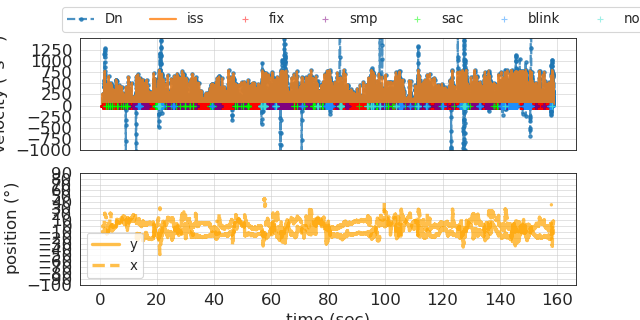

In [63]:
df = map_to_stream(test_events_df, test_df)
show_events_bool=True
show_events=['fix','smp','sac','blink', 'noise']
makePlot2(df, show_events, show_events_bool=True)

In [64]:
seq_50 = events_df.copy()
seq_51 = test_events_df_51.copy()
seq_52 = test_events_df.copy()
seq = seq_52

In [65]:
seq = seq.loc[(seq.calculus_error>-1)&(seq.calculus_error<1.5)]
seq.reset_index(inplace=True)
print(len(seq.loc[~(seq.calculus_error>-1)&~(seq.calculus_error<1.5)]))

0


<IPython.core.display.Javascript object>


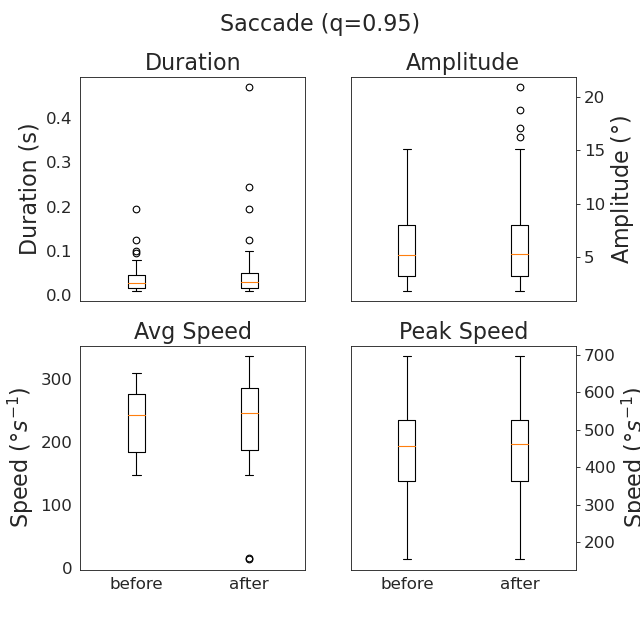

In [66]:
plot_change([seq_50, seq_52], 'sac', q=0.95)

<IPython.core.display.Javascript object>


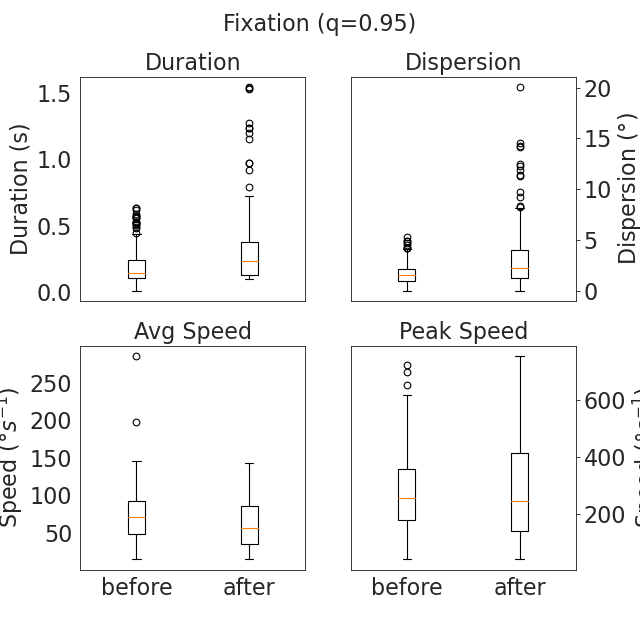

In [67]:
plot_change([seq_50, seq_52], 'fix', q=0.95)

<IPython.core.display.Javascript object>


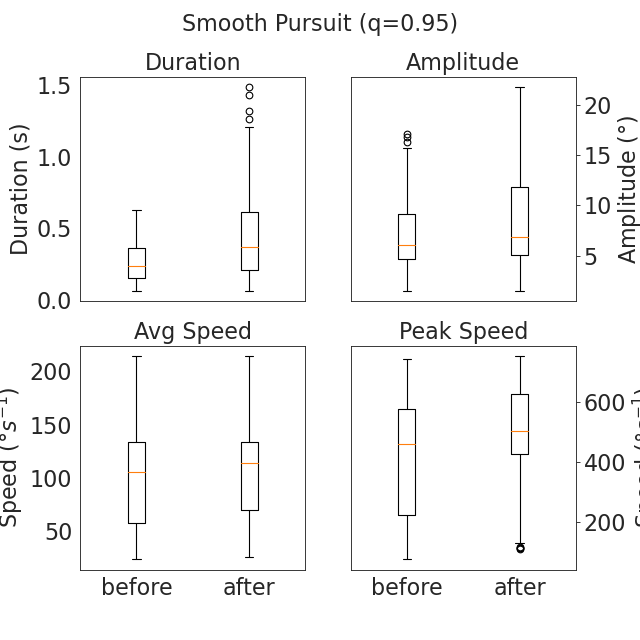

In [68]:
plot_change([seq_50, seq_52], 'smp', q=0.95)

<IPython.core.display.Javascript object>


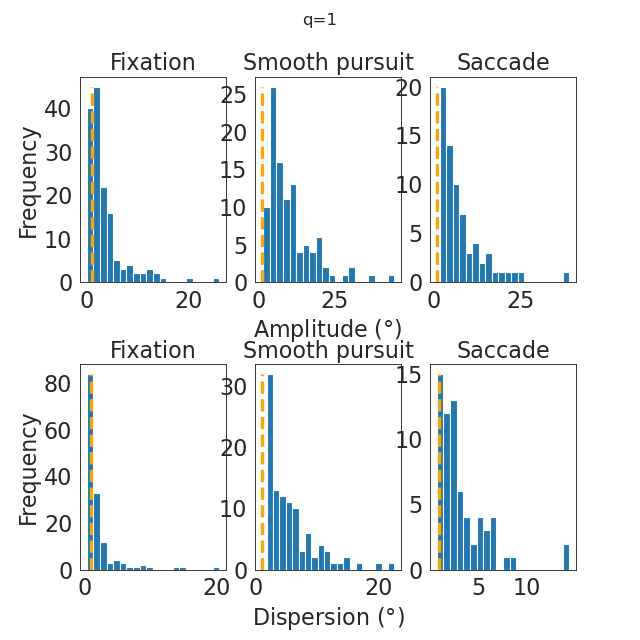

In [69]:
q = 1
seq = seq_52.copy()

states = ['fix', 'smp', 'sac']
feats = ['amplitude', 'dispersion']
titles = {'fix':'Fixation','smp':'Smooth pursuit','sac':'Saccade'}
labels = {'amplitude':'Amplitude ($\degree$)', 'dispersion':'Dispersion ($\degree$)'}

fig, ax = plt.subplots(2,3,figsize=(10,10))
    
plt.suptitle(f'q={q}', fontsize=15)

for i in range(len(feats)):
    feat = feats[i]
    for j in range(len(states)):
        e = states[j]
        y, x, _ = ax[i][j].hist(seq.loc[(seq.event==e)&(seq[feat] < seq[feat].quantile(q)),feat],bins=20)
        ax[i][j].vlines(x=1,ymin=0,ymax=y.max(),color='orange',linewidth=3,linestyle='--')
        if j == 0:
            ax[i][j].set_ylabel('Frequency', fontsize=20)
        if j == 1:
            ax[i][j].set_xlabel(labels[feat], fontsize=20)
        ax[i][j].set_title(titles[e],fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.subplots_adjust(hspace=0.4)
plt.show()

<IPython.core.display.Javascript object>


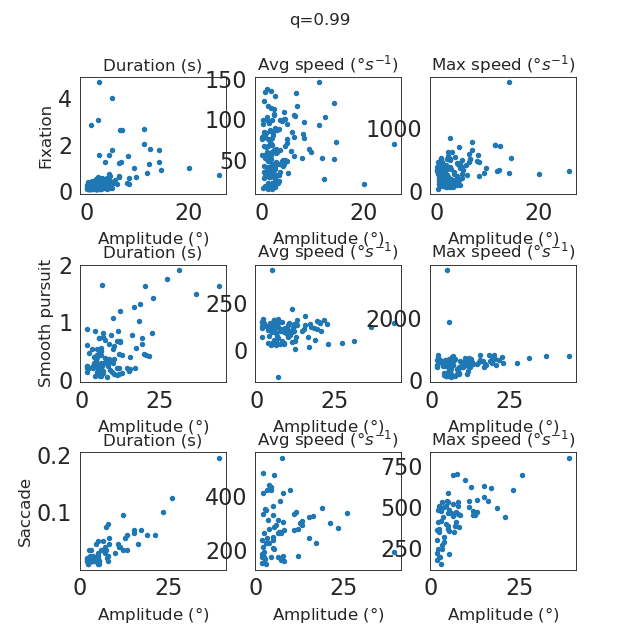

In [70]:
# plot relation between amplitude and {duration, avg_vel, max_vel}

q = 0.99
seq = seq_52.copy()

states = ['fix', 'smp', 'sac']
feats = ['duration', 'avg_Dn', 'max_Dn']
titles = {'fix':'Fixation','smp':'Smooth pursuit','sac':'Saccade'}
labels = {'duration':'Duration (s)', 'avg_Dn':'Avg speed ($\degree s^{-1}$)', 'max_Dn':'Max speed ($\degree s^{-1}$)'}

fig, ax = plt.subplots(3,3,figsize=(10,10))

plt.suptitle(f'q={q}', fontsize=15)

for i in range(len(states)):
    e = states[i]
    for j in range(len(feats)):
        y_feat = feats[j]
#         if e == 'sac':
        x_feat = 'amplitude'
        t = 'Amplitude ($\degree$)'
#         else:
#             x_feat = 'dispersion'
#             t = 'Dispersion ($\degree$)'
        temp = seq.loc[(seq.event==e)&(seq[feat] < seq[feat].quantile(q))]
        ax[i][j].scatter(temp[x_feat], temp[y_feat], s=15)
        # plot line of best fit?
        ax[i][j].set_title(labels[y_feat],fontsize=15)
        if j == 0:
            ax[i][j].set_ylabel(titles[e], fontsize=15)
        ax[i][j].set_xlabel(t, fontsize=15)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.subplots_adjust(hspace=0.6)
plt.show()

<IPython.core.display.Javascript object>


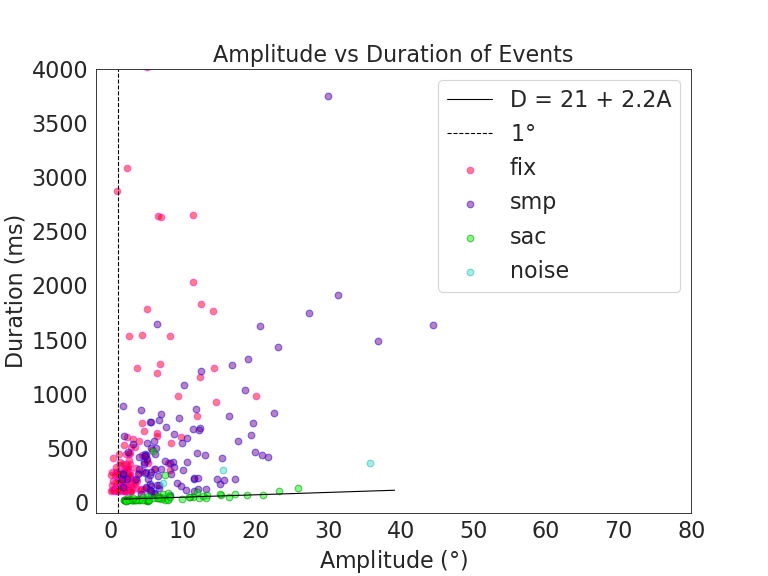

In [71]:
plot_carpenter(seq_52, show_events=['fix','smp','sac','noise'])

In [114]:
%matplotlib notebook

In [123]:
def makePlot2(df, show_events, show_events_bool=False):
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,5))


    # Plot position.
    ax[1].plot(df.time, df.y_deg, color='orange', label='y', alpha = 0.7, linewidth=3)
    ax[1].plot(df.time, df.x_deg, '--', color='orange', label='x', alpha = 0.7, linewidth=3)
    ax[1].set_ylabel('position ($\degree$)', fontsize=20)#color='orange', fontsize=10)
    ax[1].axis()

    # Plot speed.
    try:
        ax[0].plot(df.time, df.Dn, '.--', linewidth=2, alpha=0.8, label='Dn')
    except:
        pass
    #ax[0].plot(df.time, df.Dy, linewidth=3, alpha = 0.8, label="y'(t)")
    ax[0].plot(df.time, df.iss, linewidth=2, alpha = 0.8, label="iss")
    #ax.plot([df.loc[0,'time'],df.loc[len(df)-1,'time']], [0,0], color='black', label='baseline Dy=0')
    ax[0].set_ylabel("velocity ($\degree s^{-1}$)", fontsize=20)
    ax[1].set_xlabel('time (sec)',fontsize=20)

    if show_events_bool:
        # Plot each event a separate color.
        upper_bound = np.nanmin(df.iss)-20
        lower_bound = upper_bound-20    
        if len(show_events) > 0:
            for event in show_events:
                ax[0].plot(df.time, np.where(df['event']==event,0,None), '+',
                        color=COLORS[event], alpha=0.5, label=event)
                ax[0].fill_between(df.time, lower_bound, upper_bound, where= df.event == event,
                                color=COLORS[event], alpha=0.5)

    # labels
    ax[0].legend(bbox_to_anchor=(-.05,1,1,0), loc='lower left',ncol=len(show_events)+2,fontsize=20)
    ax[1].legend(fontsize=15)

    #ax.set_title('Intersample Speed vs Time')

    lower = min(df[~np.isnan(df.iss)].iss) - 5
    upper = max(df[~np.isnan(df.iss)].iss) + 5
    ax[0].set_yticks([i for i in range(-1000, 1500, 250)])
    ax[0].grid(linewidth=0.5)
    ax[0].set_ylim((-1000,1500))

#     lower = min(min(df[~np.isnan(df.x_deg)].x_deg), min(df[~np.isnan(df.y_deg)].y_deg)) - 5
#     upper = max(max(df[~np.isnan(df.x_deg)].x_deg), max(df[~np.isnan(df.y_deg)].y_deg)) + 5
    lower = min(np.nanmin(df.x_deg), np.nanmin(df.y_deg)) - 5
    upper = max(np.nanmax(df.x_deg), np.nanmax(df.y_deg)) + 5
    ax[1].set_yticks([i for i in range(-100, 100, 10)])
    ax[1].grid(linewidth=0.5)

    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)

    plt.show()

<IPython.core.display.Javascript object>


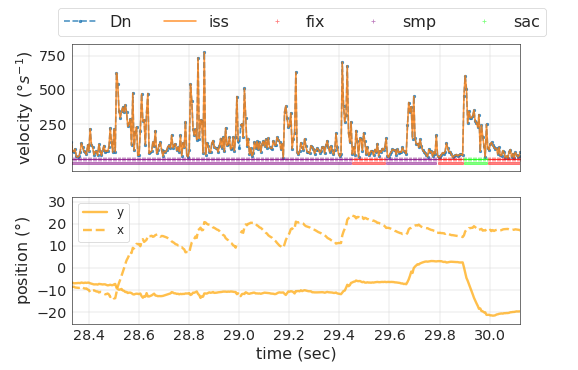

In [124]:
show_events_bool=True
show_events=['fix','smp','sac']
makePlot2(df, show_events, show_events_bool=True)

<IPython.core.display.Javascript object>


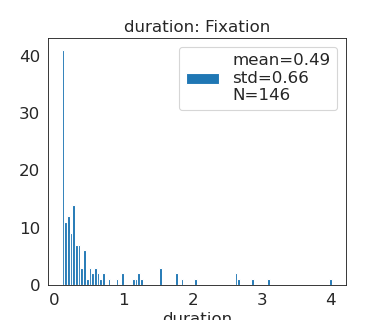

In [73]:
feature_histogram(seq,'duration','fix')

<IPython.core.display.Javascript object>


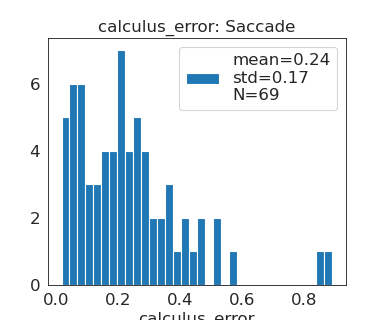

In [74]:
feature_histogram(seq, feat='calculus_error', event='sac')

<IPython.core.display.Javascript object>


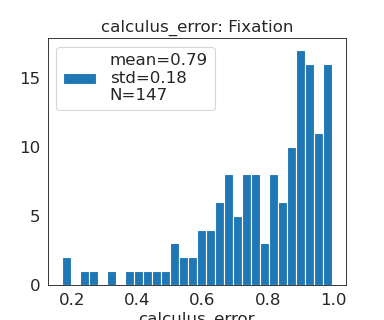

In [75]:
feature_histogram(seq, feat='calculus_error', event='fix')

<IPython.core.display.Javascript object>


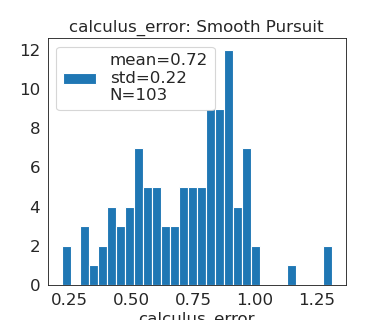

In [76]:
feature_histogram(seq, feat='calculus_error', event='smp')

<IPython.core.display.Javascript object>


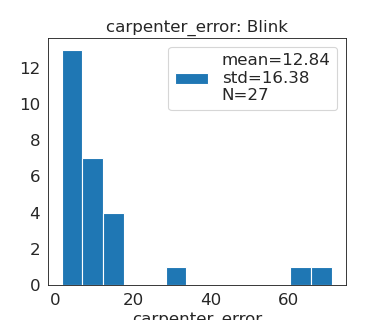

In [77]:
feature_histogram(seq, feat='carpenter_error', event='blink')

In [78]:
seq_50['subID'] = subID
seq_50['task'] = task
seq_51['subID'] = subID
seq_51['task'] = task
seq_52['subID'] = subID
seq_52['task'] = task

In [79]:
show_transition_matrix(seq_50, normalize=True)

event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.12,0.20,0.05,0.06,0.15
fix,0.70,0.42,0.65,0.52,0.50
sac,0.00,0.14,0.00,0.11,0.10
smp,0.12,0.22,0.29,0.26,0.22


In [80]:
show_transition_matrix(seq_51, normalize=True)

event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.13,0.04,0.06,0.04,0.06
fix,0.42,0.50,0.65,0.53,0.51
sac,0.03,0.18,0.00,0.11,0.13
smp,0.29,0.27,0.28,0.26,0.27


In [81]:
show_transition_matrix(seq_52, normalize=True)

event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.00,0.07,0.06,0.05,0.07
fix,0.48,0.08,0.65,0.72,0.40
sac,0.04,0.34,0.00,0.15,0.19
smp,0.33,0.49,0.28,0.00,0.29


In [82]:
print(START,END)

200 800


In [90]:
%matplotlib inline

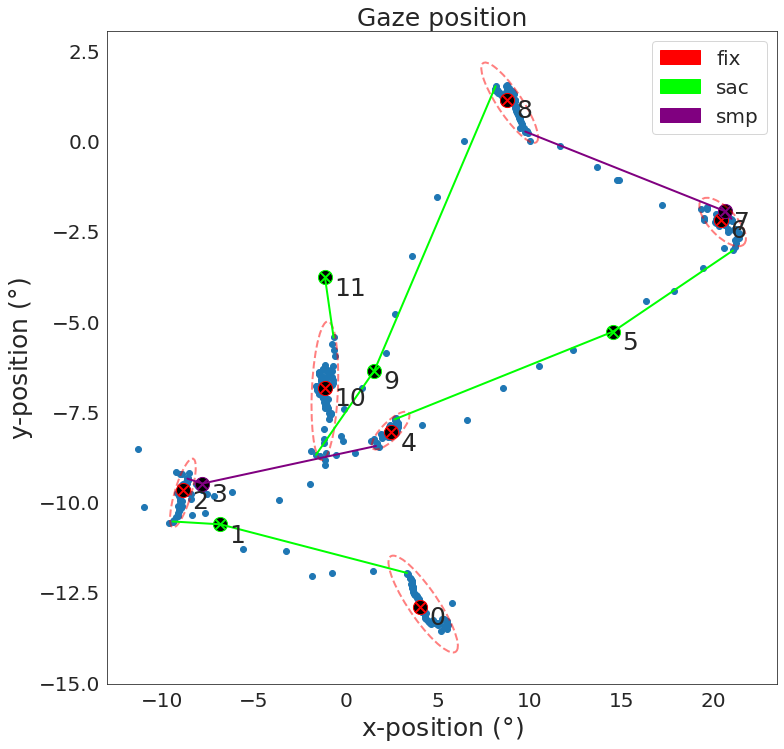

In [108]:
# Plot sample spatial scatter using fix centers, sac and smp (x0,y0) and (xn,yn)
START, END = 255, 800
# make temp events_df using events that fall within the START and END times
temp = seq_52.loc[(seq_52.start_s>df.loc[START,'time'])&(seq_52.end_s<df.loc[END,'time'])]

plot_events_scatter(temp, df, START, END)

In [84]:
temp.loc[:,:'yn']

,event,start_i,end_i,start_s,end_s,duration,amplitude,dispersion,center_x,center_y,x0,y0,xn,yn
22,sac,1244,1246,7.364025,7.384037,0.020011,4.916198,1.97079,4.9,10.27,2.607191,9.174629,5.007944,11.305118
23,fix,1247,1302,7.384037,7.659133,0.275096,2.68763,1.069882,6.35,11.19,5.007944,11.305118,7.604935,10.613025
24,fix,1303,1390,7.664135,8.09927,0.435135,4.28949,2.078017,11.3,11.01,9.232443,11.982821,11.812967,8.556362
25,sac,1391,1394,8.09927,8.124284,0.025014,3.784547,1.844715,14.53,8.17,11.812967,8.556362,15.597431,8.531276
26,smp,1395,1507,8.124284,8.684423,0.560139,6.032316,1.911772,16.19,5.93,15.597431,8.531276,15.624022,2.499019
27,sac,1508,1509,8.684423,8.69943,0.015008,2.229689,1.261325,16.92,3.54,15.624022,2.499019,17.325372,3.940171
28,smp,1510,1639,8.694428,9.379652,0.685224,12.363803,5.946107,13.44,4.32,17.203906,3.891879,5.521529,7.939806
29,sac,1640,1649,9.37465,9.429661,0.055012,8.056281,3.436359,5.31,7.67,6.170821,7.915253,-1.763664,6.519691
30,fix,1650,1689,9.429661,9.624729,0.195068,0.403886,0.379104,-1.76,6.18,-1.763664,6.519691,-1.484587,6.227733
31,sac,1690,1695,9.624729,9.659734,0.035005,7.177305,3.325976,-4.96,8.61,-1.484587,6.227733,-6.953828,10.689309


In [85]:
temp_ = events_df.loc[(events_df.end_s>df.loc[START,'time'])&(events_df.start_s<df.loc[END,'time'])]
temp_.loc[:,:'yn']

,event,start_i,end_i,start_s,end_s,duration,amplitude,dispersion,center_x,center_y,x0,y0,xn,yn
26,fix,1155,1243,6.923879,7.364025,0.440146,1.180938,1.007666,1.58,10.00,1.915521,10.131816,2.607191,9.174629
27,sac,1244,1246,7.364025,7.384037,0.020011,4.916198,1.970790,4.90,10.27,2.607191,9.174629,5.007944,11.305118
28,fix,1247,1302,7.384037,7.659133,0.275096,2.687630,1.069882,6.35,11.19,5.007944,11.305118,7.604935,10.613025
29,fix,1303,1326,7.659133,7.784167,0.125035,3.931270,1.551346,10.88,13.04,7.604935,10.613025,11.301377,11.951383
30,fix,1327,1390,7.784167,8.099270,0.315103,3.433350,1.354406,11.41,10.42,11.301377,11.951383,11.812967,8.556362
31,sac,1391,1394,8.099270,8.124284,0.025014,3.784547,1.844715,14.53,8.17,11.812967,8.556362,15.597431,8.531276
32,smp,1395,1507,8.124284,8.684423,0.560139,6.032316,1.911772,16.19,5.93,15.597431,8.531276,15.624022,2.499019
33,sac,1508,1509,8.684423,8.699430,0.015008,2.229689,1.261325,16.92,3.54,15.624022,2.499019,17.325372,3.940171
34,smp,1510,1584,8.699430,9.069539,0.370109,5.024734,2.453897,15.45,3.23,17.325372,3.940171,12.490600,2.571620
35,smp,1585,1603,9.069539,9.199590,0.130050,6.908096,3.323334,11.53,8.20,12.490600,2.571620,10.978628,9.312223


<IPython.core.display.Javascript object>


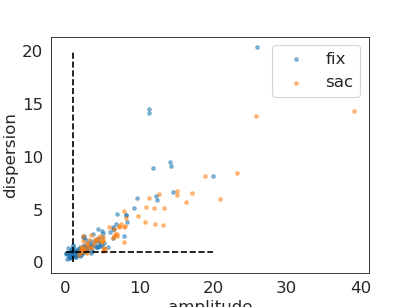

In [86]:
plt.figure()
plt.scatter(seq_52[seq_52.event=='fix'].amplitude, seq_52[seq_52.event=='fix'].dispersion,label='fix',s=10,alpha=.5)
plt.scatter(seq_52[seq_52.event=='sac'].amplitude, seq_52[seq_52.event=='sac'].dispersion,label='sac',s=10,alpha=.5)
#plt.scatter(seq_52[seq_52.event=='sac'].amplitude, seq_52[seq_52.event=='sac'].dispersion,label='sac',s=10,alpha=.5)
plt.vlines(x=1,ymin=0,ymax=20,linestyle='--',color='black')
plt.hlines(y=1,xmin=0,xmax=20,linestyle='--',color='black')
plt.legend(fontsize=15)
plt.xlabel('amplitude',fontsize=15)
plt.ylabel('dispersion',fontsize=15)
plt.show()

In [87]:
print('Saccades under 1 deg')
print(np.round(len(seq_52.loc[(seq_52.event=='sac')&(seq_52.amplitude<1)])/len(seq_52[seq_52.event=='sac'])*100,2),'%')

print('\nSmooth Pursuit under 1 deg')
print(np.round(len(seq_52.loc[(seq_52.event=='smp')&(seq_52.amplitude<1)])/len(seq_52[seq_52.event=='smp'])*100,2),'%')


Saccades under 1 deg
0.0 %

Smooth Pursuit under 1 deg
0.0 %
